In [3]:
import numpy as np
import pymc as pm

count_data = np.loadtxt('data/txtdata.csv')
n_count_data = len(count_data)
alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper= n_count_data)

print "Random output of tau:", tau.random(), tau.random(), tau.random()

Couldn't import dot_parser, loading of dot files will not be possible.
Random output of tau: 65 0 41


In [4]:
#although this is a stochastic function PyMC uses this @pm.deterministic 
#as a decorator
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    """
    Generates a random variable lambda based on value of tau
    """
    output = np.zeros(n_count_data)
    output[:tau] = lambda_1 #lambda before event tau is lambda_1
    output[tau:] = lambda_2 #lambda after evetnt tau is lambda_2
    return output



In [5]:
observation = pm.Poisson('obs', lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [6]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 7.4 sec

In [7]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

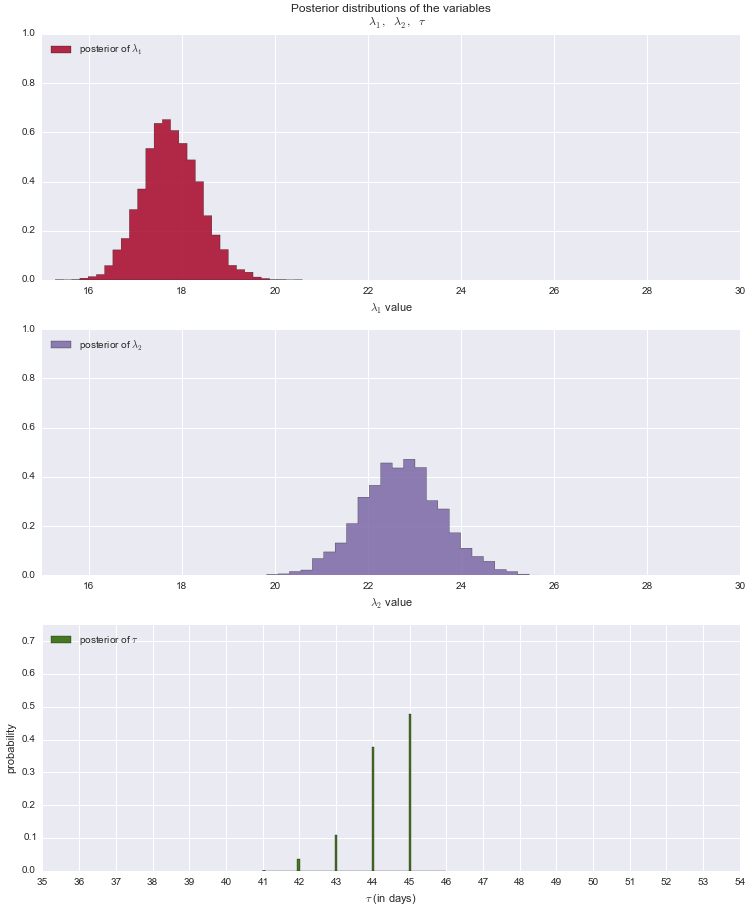

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

from pylab import rcParams
rcParams['figure.figsize'] = 12.5, 15

#figure(figsize(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

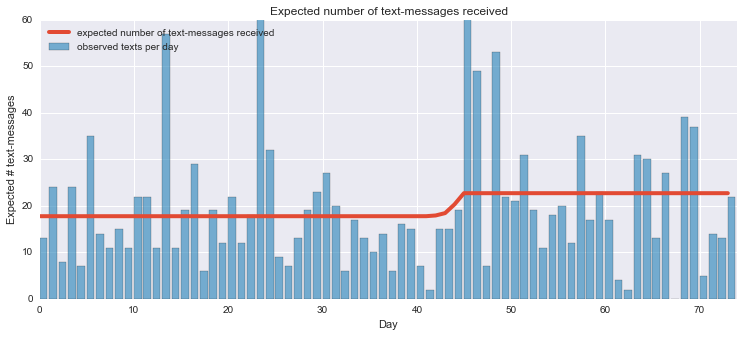

In [10]:
rcParams['figure.figsize'] = 12.5, 5

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    
    ix = day < tau_samples
    #to estimate the number of texts per day we need to estimate the paramter
    #lambda. We've assumed the text counts are similar to a Poisson distribution
    #We said that lambda is dependent upon a variable tau
    #to determine which regime we are in lambda1 or lambda2 we 
    #can check which day we are in and ad up the expected values of Lambda for that 
    #day and get an expected message count
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() +
                                   lambda_2_samples[~ix].sum()) / N
    
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

In [11]:
print "Mean of Posterior Distributions for Lambda"
print "------------------------------------------"
print "Lambda 1 Mean:", lambda_1_samples.mean()
print "Lambda 2 Mean:", lambda_2_samples.mean()

Mean of Posterior Distributions for Lambda
------------------------------------------
Lambda 1 Mean: 17.7645127261
Lambda 2 Mean: 22.7151158724


In [12]:
print "Expected percentage increase in text message rates"
(lambda_1_samples / lambda_2_samples).mean()

Expected percentage increase in text message rates


0.78321472726369246

In [13]:
#Observed mean
expected_texts_per_day[0:45].mean()

17.83921031165908

In [14]:
#Predicted mean
lambda_1_samples[0:45].mean()

18.134317160969246

Overview of PyMC stuff



In [37]:
#PyMC deals with Stochastic and Deterministic variables

#Stochastic classes: Poisson, Exponential, DiscreteUniform
#Initialize Stochastic Vars by indicating a class type
lambda_1 = pm.Exponential("lambda_1", 1) #prior on first regime
lambda_2 = pm.Exponential("lambda_2", 1) #prior on second regime
tau = pm.DiscreteUniform("tau", lower=0, upper=10) #prior on regime change


print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value
print 

#Now call random on the stochastic vars

lambda_1.random(), lambda_2.random(), tau.random()


print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value

lambda_1.value = 0.352
lambda_2.value = 0.342
tau.value = 9.000

lambda_1.value = 1.218
lambda_2.value = 0.201
tau.value = 10.000


In [38]:
#running elementary operations creates deterministic vars
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [47]:
import numpy as np

n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    output = np.zeros(n_data_points)
    output[:tau] = lambda_1
    output[tau:] = lambda_2
    return output

#Given that we have values of lambda_1, lambda_2 and tau,
#our variable lambda_ is deterministic

#the stochastic variables behave like scalars



(0, 8)

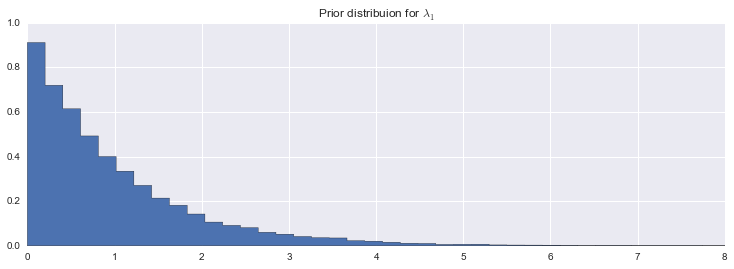

In [43]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples,bins = 70, normed = True, histtype="stepfilled")
plt.title("Prior distribuion for $\lambda_1$")
plt.xlim(0,8)

In [45]:
data = np.array([10,5])

fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print "value:", fixed_variable.value
print "calling .random()"
fixed_variable.random()

print "value:", fixed_variable.value

#As we see that when we set observed=True it sets the "value" param



value: [10  5]
calling .random()
value: [10  5]


This is how to include data into our models: initialize a stochastic variable to have a fixed value

In [48]:
data = np.array([10,25,15,20,35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


In [49]:
#We complete this process by wrapping the variables in a 
#pm.Model class

model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

Ask yourself always "How could this data have been generated"
Imagine how to recreate the dataset

In [57]:
#Lets see if we can recreate our dataset with in the spirit of a
#Monte Carlo Simulation
tau = pm.rdiscrete_uniform(0,80)
print tau
#tau is random

44


In [64]:
#now lets create some lambda generators
#draw lambda_1 and lambda_2 from an exponential distribution
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2b

19.369466957 70.3967850445


To represent SMS count for days prior to tau we can sample from a Poisson of lambda_1.
For days post tau we can sample from lambda_2

In [65]:
data = np.r_[pm.rpoisson(lambda_1,tau), pm.rpoisson(lambda_2, 80-tau)]



Let's plot out simulated data set

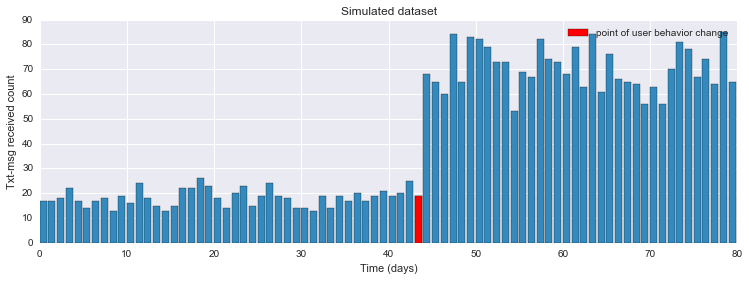

In [67]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau-1], color= "r", label= "point of user behavior change")
plt.xlabel("Time (days)")
plt.ylabel("Txt-msg received count")
plt.title("Simulated dataset")
plt.xlim(0,80)
plt.legend();

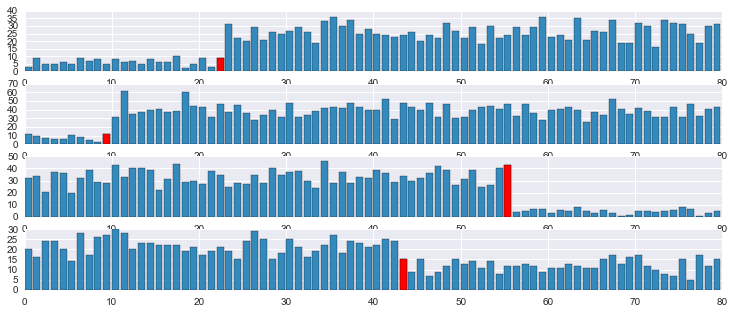

In [76]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0,80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau-1, data[tau-1], color="r", label="user behavior change")
    plt.xlim(0,80)
    
figsize(12.5, 5)

plt.title("Multiple simulations to demonstrate")
for i in range(1,5):
    plt.subplot(4,1,i)
    plot_artificial_sms_dataset()
    
